# Advanced: Extending lambeq

In this tutorial you will find examples of how to extend `lambeq` to add more readers, rewrite rules and ansätze, so you can start making your own [contributions](https://github.com/CQCL/lambeq/pulls) to the toolkit.

## Creating readers

The [Reader](../lambeq.rst#lambeq.reader.Reader) class is an abstract base class for converting sentences to diagrams. Each reader can be seen as a different compositional model, and `lambeq` can accommodate any compositional model that represents sentences in a string diagram/tensor network form.

A concrete subclass of [Reader](../lambeq.rst#lambeq.reader.Reader) should implement the `sentence2diagram` method, which converts a single sentence into a rigid diagram.

### [Reader](../lambeq.rst#lambeq.reader.Reader) example: "Comb" reader

In this example we will create a reader that, given a sentence, it generates the following tensor network:

<center>
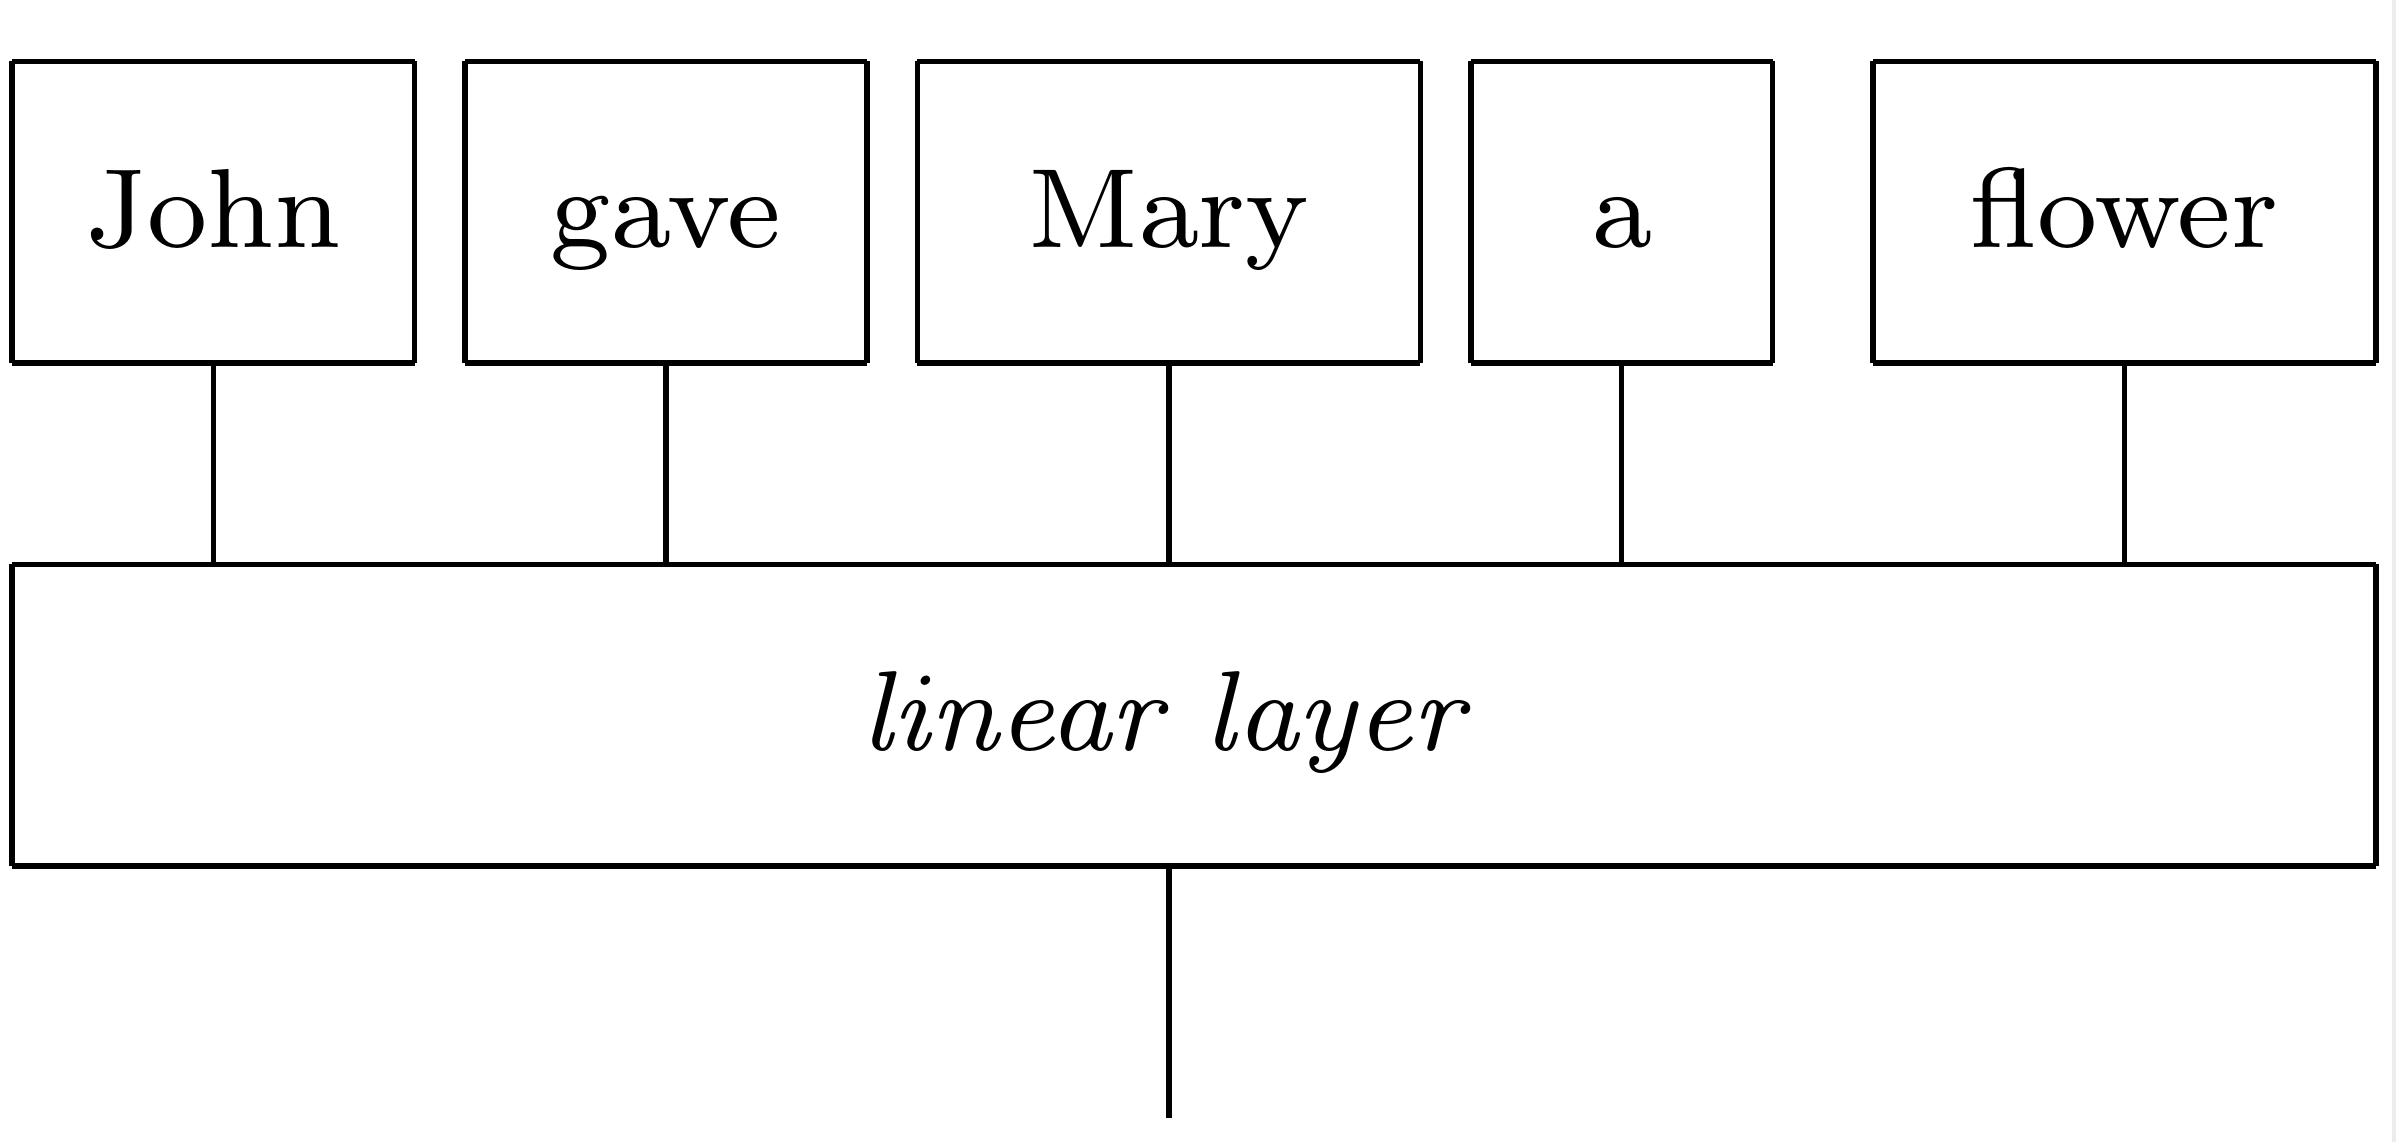
</center>

Note that the particular compositional model is not appropriate for classical experiments, since the tensor that implements the layer can become very large for long sentences. However, the model can be implemented without problems on a quantum computer.

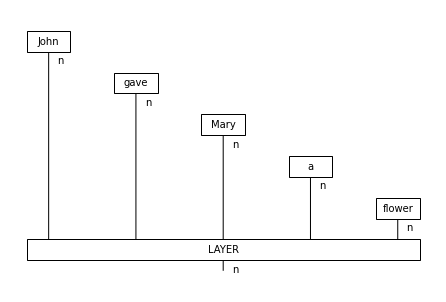

In [1]:
from lambeq.reader import Reader
from lambeq.core.types import AtomicType
from discopy import Box, Id, Word

N = AtomicType.NOUN

class CombReader(Reader):
    def sentence2diagram(self, sentence):
        words = Id().tensor(*[Word(w, N) for w in sentence.split()])
        layer = Box('LAYER', words.cod, N)
        return words >> layer

diagram = CombReader().sentence2diagram('John gave Mary a flower')
diagram.draw()

Note that, in the above code, the method `tensor()` refers to the monoidal product and not to a physical tensor object. What the specific line does, using the monoidal identity `Id()` as a starting point, is to tensor one-by-one the boxes of the words in the sentence accumulatively, from left to right, into a single diagram, as in a standard fold operation. 

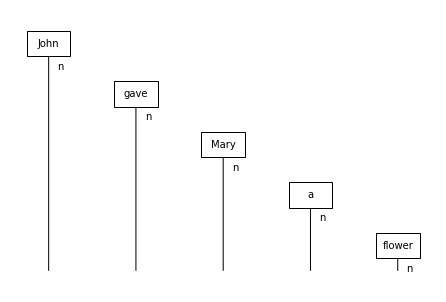

In [2]:
Id().tensor(*[Word(w, N) for w in ['John', 'gave', 'Mary', 'a', 'flower']]).draw()

This diagram is then combined with the `layer` box to create the final output of the reader.

<div class="alert alert-info">

**Note**
    
In an actual implementation, the `layer` Box should be shared among all sentences so it can be trained properly.

</div>    

## Creating rewrite rules

In [3]:
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

from lambeq.ccg2discocat import DepCCGParser

parser = DepCCGParser()
d = parser.sentence2diagram('The food is fresh')

### [SimpleRewriteRule](../lambeq.rst#lambeq.rewrite.SimpleRewriteRule) example: Negation functor

The [SimpleRewriteRule](../lambeq.rst#lambeq.rewrite.SimpleRewriteRule) class contains functionality that facilitates the creation of simple rewrite rules, without the need to define a new [RewriteRule](../lambeq.rst#lambeq.rewrite.RewriteRule) class from scratch. A [SimpleRewriteRule](../lambeq.rst#lambeq.rewrite.SimpleRewriteRule) finds words with codomain `cod` and name in list `words`, then replaces their boxes with the diagram in `template`. 

Here is an example of a negation functor using [SimpleRewriteRule](../lambeq.rst#lambeq.rewrite.SimpleRewriteRule). The functor adds a "NOT" box to the wire of certain auxiliary verbs:

In [4]:
from lambeq.rewrite import SimpleRewriteRule
from lambeq.core.types import AtomicType
from discopy.rigid import Box, Id

N = AtomicType.NOUN
S = AtomicType.SENTENCE
adj = N @ N.l

NOT = Box('NOT', S, S)

negation_rewrite = SimpleRewriteRule(
    cod=N.r @ S @ S.l @ N,
    template=SimpleRewriteRule.placeholder(N.r @ S @ S.l @ N) >> Id(N.r) @ NOT @ Id(S.l @ N),
    words=['is', 'was', 'has', 'have'])

<div class="alert alert-info">
    
**Note**
    
The placeholder `SimpleRewriteRule.placeholder(t)` in the template above will be replaced by a box with the same name as the original box and type `t`.

</div>

A list of [RewriteRule](../lambeq.rst#lambeq.rewrite.RewriteRule)s can be passed to [Rewriter](../lambeq.rst#lambeq.rewrite.Rewriter) to create a rewriting functor. If no list is provided, then the default rewriting rules are used (see [Diagram Rewriting](./rewrite.ipynb)).

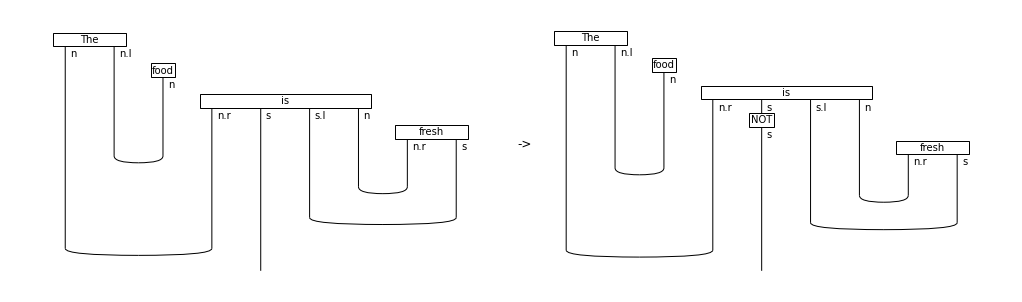

In [5]:
from lambeq.rewrite import Rewriter
from discopy import drawing

not_d = Rewriter([negation_rewrite])(d)
drawing.equation(d, not_d, symbol='->', figsize=(14, 4))

### [RewriteRule](../lambeq.rst#lambeq.rewrite.RewriteRule) example: "Past" functor

Sometimes, a rewrite rule may become too complicated to be implemented using the [SimpleRewriteRule](../lambeq.rst#lambeq.rewrite.SimpleRewriteRule) class, so the more general [RewriteRule](../lambeq.rst#lambeq.rewrite.RewriteRule) class should be used instead. A concrete subclass of a [RewriteRule](../lambeq.rst#lambeq.rewrite.RewriteRule) should implement the methods `matches()` and `rewrite()`.

A rewriter uses the `matches()` methods of its [RewriteRule](../lambeq.rst#lambeq.rewrite.RewriteRule)s to detect if a  rule can be applied. If there is a match, then the matching box is replaced with the result of `rewrite(box)`. 

In the following example, a functor that changes the tense of certain auxiliary verbs is implemented by directly subclassing [RewriteRule](../lambeq.rst#lambeq.rewrite.RewriteRule):

In [6]:
from lambeq.rewrite import RewriteRule

class PastRewriteRule(RewriteRule):
    mapping = {
        'is': 'was',
        'are': 'were',
        'has': 'had'
    }
    def matches(self, box):
        return box.name in self.mapping
    
    def rewrite(self, box):
        new_name = self.mapping[box.name]
        return type(box)(name=new_name, dom=box.dom, cod=box.cod)

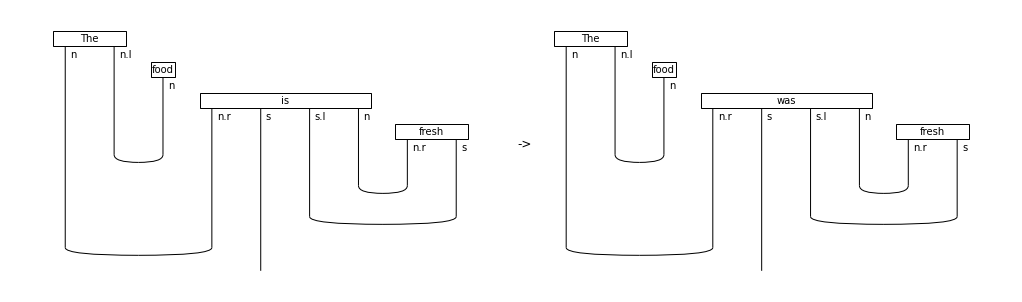

In [7]:
past_d = Rewriter([PastRewriteRule()])(d)
drawing.equation(d, past_d, symbol='->', figsize=(14, 4))

## Creating ansätze

In [8]:
d = parser.sentence2diagram('We will go')

Ansätze for the quantum pipeline are implemented by extending the [CircuitAnsatz](../lambeq.rst#lambeq.circuit.CircuitAnsatz) class, while ansätze for the classical pipeline need to extend the [TensorAnsatz](../lambeq.rst#lambeq.tensor.TensorAnsatz) class. Both classes extend [BaseAnsatz](../lambeq.rst#lambeq.ansatz.BaseAnsatz), sharing a common interface. Once an ansatz is instantiated, it can be used as a functor to convert diagrams to either a circuit or a tensor diagram.

An ansatz should be initialised with an `ob_map` argument, a dictionary which maps a rigid type to the number of qubits in the quantum case, or to a dimension size (e.g. `Dim(2, 2)`) for the classical case. Some ansätze may require additional arguments (see the [API documentation](../lambeq.rst) for more details).

In DisCoPy, a functor is defined by specifying the mappings for objects `ob` and arrows `ar`. The [CircuitAnsatz](../lambeq.rst#lambeq.circuit.CircuitAnsatz) and [TensorAnsatz](../lambeq.rst#lambeq.tensor.TensorAnsatz) classes already implement the `_ob` method, which extends `ob_map` to map not just base (atomic) types, but also compound types, into qubits and dimensions respectively. Therefore, to complete a new ansatz class, you only need to implement the `_ar` method, i.e. the mapping from rigid boxes to diagrams. This typically involves the following steps:

1. Obtain the label of the box using the `_summarise_box` method. This provides a unique token which can be used to parameterise the box.
2. Apply the functor to the domain and the codomain of the box using the `_ob` method.
3. Construct and return an ansatz with new domain and codomain - see how to construct diagrams using DisCoPy [here](https://discopy.readthedocs.io/en/main/notebooks.html).

### [CircuitAnsatz](../lambeq.rst#lambeq.circuit.CircuitAnsatz) example: "Real-valued" ansatz

This ansatz always returns a tensor with real-valued entries, since the ansatz is constructed using only the CNOT and Y rotation gates, which both implement real-valued unitaries.

In [9]:
from lambeq.circuit import CircuitAnsatz
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.gates import Bra, CX, Ket, Ry
from lambeq.ansatz import Symbol

class RealAnsatz(CircuitAnsatz):
    def __init__(self, ob_map, n_layers):
        super().__init__(ob_map=ob_map, n_layers=n_layers)

        self.n_layers = n_layers
        self.functor = Functor(ob=self.ob_map, ar=self._ar)


    def _ar(self, box):
        # step 1: obtain label
        label = self._summarise_box(box)

        # step 2: map domain and codomain
        dom, cod = self._ob(box.dom), self._ob(box.cod)

        n_qubits = max(dom, cod)
        n_layers = self.n_layers
        
        # step 3: construct and return ansatz
        if n_qubits == 1:
            circuit = Ry(Symbol(f'{label}_0'))
        else:
            # this also deals with the n_qubits == 0 case correctly
            circuit = Id(n_qubits)
            for i in range(n_layers):
                offset = i * n_qubits
                syms = [Symbol(f'{label}_{offset + j}') for j in range(n_qubits)]

                # adds a ladder of CNOTs
                for j in range(n_qubits - 1):
                    circuit >>= Id(j) @ CX @ Id(n_qubits - j - 2)

                # adds a layer of Y rotations
                circuit >>= Id().tensor(*[Ry(sym) for sym in syms])

        if cod <= dom:
            circuit >>= Id(cod) @ Bra(*[0]*(dom - cod))
        else:
            circuit <<= Id(dom) @ Ket(*[0]*(cod - dom))
        return circuit

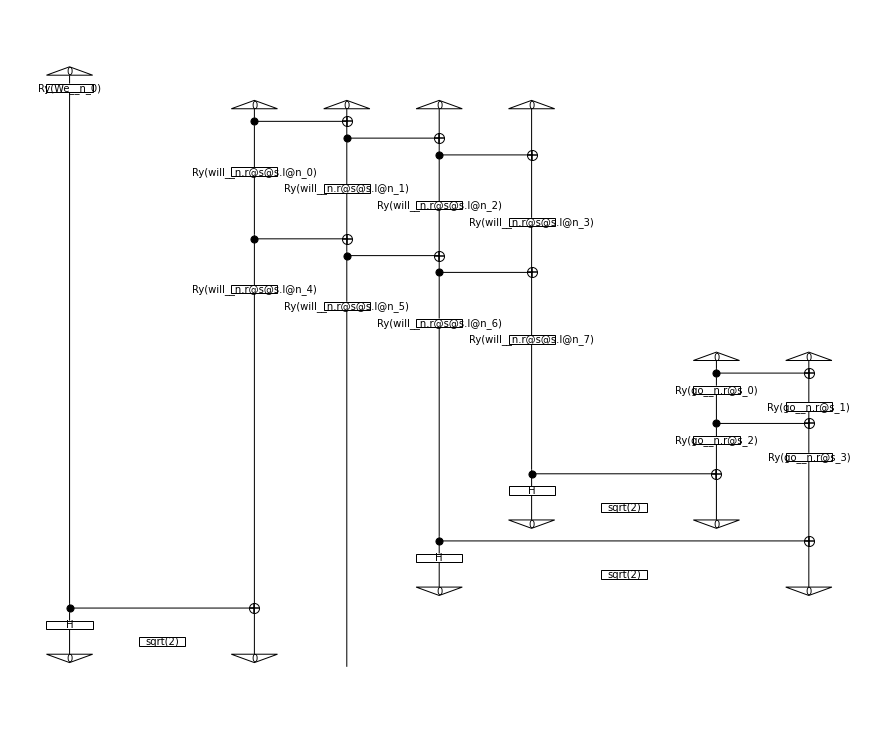

In [10]:
real_d = RealAnsatz({N: 1, S: 1}, n_layers=2)(d)
real_d.draw(figsize=(12, 10))

### [TensorAnsatz](../lambeq.rst#lambeq.tensor.TensorAnsatz) example: "Positive" ansatz

This ansatz returns a positive tensor, since the individual tensors are element-wise squared before contracted.

In [11]:
from lambeq.tensor import TensorAnsatz
from discopy import rigid, tensor
from functools import reduce

class PositiveAnsatz(TensorAnsatz):
    def _ar(self, box):
        # step 1: obtain label
        label = self._summarise_box(box)

        # step 2: map domain and codomain
        dom, cod = self._ob(box.dom), self._ob(box.cod)

        # step 3: construct and return ansatz
        name = self._summarise_box(box)
        n_params = reduce(lambda x, y: x * y, dom @ cod, 1)
        syms = Symbol(name, size=n_params)
        return tensor.Box(box.name, dom, cod, syms ** 2)

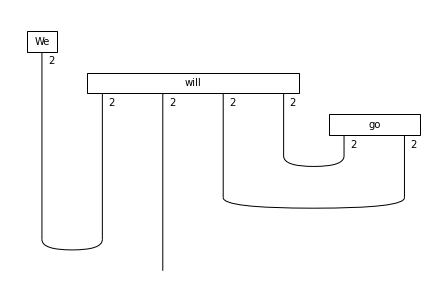

In [12]:
from discopy import Dim

ansatz = PositiveAnsatz({N: Dim(2), S: Dim(2)})
positive_d = ansatz(d)
positive_d.draw()

In [13]:
import numpy as np
from sympy import default_sort_key

syms = sorted(positive_d.free_symbols, key=default_sort_key)
sym_dict = {k: -np.ones(k.size) for k in syms}
subbed_diagram = positive_d.lambdify(*syms)(*sym_dict.values())

subbed_diagram.eval()

Tensor(dom=Dim(1), cod=Dim(2), array=[8., 8.])

## Contributions

We encourage you to implement your own readers, rewrite rules and ansätze and [contribute to lambeq](https://github.com/CQCL/lambeq/pulls) - detailed guidelines are available [here](../CONTRIBUTING.rst). Below you can find some sources of inspiration:

* rewrites for relative pronouns: [[link 1]](https://arxiv.org/abs/1404.5278) [[link 2]](https://arxiv.org/abs/1406.4690)
* rewrites to deal with coordination: [[link]](https://arxiv.org/abs/1606.01515)
* rewrites to reduce the dimension size of verbs: [[link]](https://arxiv.org/abs/1401.5980)
* rewrites to language circuits (DisCoCirc): [[link]](https://arxiv.org/abs/2106.07485)

* ansätze benchmarked by their expressibility: [[link]](https://arxiv.org/abs/1905.10876)
* high-level examples of ansätze: [[link]](https://pennylane.ai/qml/glossary/circuit_ansatz.html)